# 🧠 Tuning: Estrategia EMA 9/21 Cruce v3

### 🎯 Objetivo
Evaluar y optimizar la estrategia **ema_9_21_cruce_v3**, basada en el cruce de medias móviles exponenciales (EMA) de 9 y 21 periodos. Esta estrategia busca detectar señales de reversión de tendencia a partir del momentum de precios, combinadas opcionalmente con un filtro de volatilidad.

---

### ⚙️ Lógica de la Estrategia
1. **Cruce de EMAs**:
   - Señal **buy**: cuando la EMA 9 cruza por encima de la EMA 21.
   - Señal **sell**: cuando la EMA 9 cruza por debajo de la EMA 21.
2. **Confirmación de cruce**:
   - Se puede requerir que el cruce se mantenga durante `N` días (`dias_cruce`) para ser considerado válido.
3. **Filtro de volatilidad (opcional)**:
   - Se aplica un filtro basado en el ATR (Average True Range), normalizado respecto al precio (`atr_ratio`).
   - Se emite señal solo si `atr_ratio > atr_threshold`.

---

### 🔬 Parámetros evaluados
- `usar_vol`: Activar o no el filtro de volatilidad.
- `atr_threshold`: Umbral mínimo de `atr_ratio` para validar una señal.
- `dias_cruce`: Número mínimo de días consecutivos manteniendo el cruce EMA para confirmar señal.

---

### 📦 Dataset y backtesting
- Señales generadas desde históricos reales (archivos `.parquet`) para 48 símbolos.
- Simulación de cada señal con una ventana de 7 días para evaluar su resultado.
- Se calcula `winrate`, `avg_profit`, `score`, y otros KPIs.

---

### 📊 Objetivo del Tuning
Encontrar la mejor combinación de parámetros que **maximice la ganancia promedio por operación** y **mantenga un winrate competitivo**, manteniendo una frecuencia operativa razonable.



In [1]:
import sys
sys.path.append("D:/trading")

In [2]:
# 📓 Notebook: tuning_ema_9_21_cruce_v3

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed

# Cargar históricos
ruta_historicos = "D:/trading/data/historic"
historicos = {}
for archivo in os.listdir(ruta_historicos):
    if archivo.endswith(".parquet"):
        ticker = archivo.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(ruta_historicos, archivo))
        historicos[ticker] = df
print(f"✅ Símbolos cargados: {len(historicos)}")

✅ Símbolos cargados: 48


In [3]:
param_grid = list(itertools.product(
    [True],                      # usar_filtro_volatilidad
    [0.006, 0.0075, 0.0085, 0.0095, 0.01],# atr_threshold
    [2, 3, 4]                           # dias_cruce
))
print(f"🔍 Total combinaciones: {len(param_grid)}")

🔍 Total combinaciones: 15


In [4]:
import sys
sys.path.append("D:/trading")
from my_modules.estrategias.v3 import ema_9_21_cruce_v3

In [5]:
def simular_combinacion(usar_vol, atr_th, dias_cruce):
    resultados = []

    for ticker, df in historicos.items():
        df_signals = ema_9_21_cruce_v3.generar_senales(
            df,
            usar_filtro_volatilidad=usar_vol,
            atr_threshold=atr_th,
            dias_cruce=dias_cruce,
            debug=False
        )
        df_signals = df_signals[df_signals.signal != "hold"]
        if df_signals.empty:
            continue

        df_precio = df.copy()
        df_precio["fecha"] = pd.to_datetime(df_precio["fecha"])
        df_signals["fecha"] = pd.to_datetime(df_signals["fecha"])
        df_merged = df_precio.merge(df_signals, on="fecha")

        for _, row in df_merged.iterrows():
            fecha_entrada = row["fecha"]
            precio_entrada = row["close"]

            df_rango = df_precio[(df_precio["fecha"] > fecha_entrada) & (df_precio["fecha"] <= fecha_entrada + pd.Timedelta(days=7))]
            if df_rango.empty:
                continue

            tipo_salida = "TIMEOUT"
            fila_salida = df_rango.iloc[-1]

            for _, f in df_rango.iterrows():
                if row["signal"] == "buy":
                    if f["high"] >= precio_entrada * 1.05:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["low"] <= precio_entrada * 0.97:
                        tipo_salida = "SL"; fila_salida = f; break
                elif row["signal"] == "sell":
                    if f["low"] <= precio_entrada * 0.95:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["high"] >= precio_entrada * 1.03:
                        tipo_salida = "SL"; fila_salida = f; break

            precio_salida = fila_salida["close"]
            dias = (fila_salida["fecha"] - fecha_entrada).days
            resultado = precio_salida - precio_entrada if row["signal"] == "buy" else precio_entrada - precio_salida
            ret_pct = (precio_salida / precio_entrada - 1) * (1 if row["signal"] == "buy" else -1)
            log_ret = np.log(precio_salida / precio_entrada) * (1 if row["signal"] == "buy" else -1)

            resultados.append({
                "usar_vol": usar_vol,
                "atr_threshold": atr_th,
                "dias_cruce": dias_cruce,
                "resultado": resultado,
                "resultado_pct": ret_pct,
                "log_ret": log_ret,
                "f_win": int(resultado > 0),
                "dias": dias
            })

    df = pd.DataFrame(resultados)
    if df.empty:
        return {
            "usar_vol": usar_vol,
            "atr_threshold": atr_th,
            "dias_cruce": dias_cruce,
            "n_trades": 0,
            "winrate": 0,
            "avg_profit": 0,
            "score": -999
        }

    return {
        "usar_vol": usar_vol,
        "atr_threshold": atr_th,
        "dias_cruce": dias_cruce,
        "n_trades": len(df),
        "winrate": df["f_win"].mean(),
        "avg_profit": df["resultado"].mean(),
        "score": df["resultado"].mean() * df["f_win"].mean()
    }




In [6]:
tareas = Parallel(n_jobs=-1)(
    delayed(simular_combinacion)(vol, atr, dias)
    for vol, atr, dias in tqdm(param_grid)
)

resultados = pd.DataFrame(tareas).sort_values("score", ascending=False).reset_index(drop=True)
print("✅ Top combinaciones:")
display(resultados.head(10))

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 121.34it/s]


✅ Top combinaciones:


,usar_vol,atr_threshold,dias_cruce,n_trades,winrate,avg_profit,score
0,True,0.0095,2,159600,0.469568,0.009380,0.004404
1,True,0.0075,2,161186,0.469842,0.009354,0.004395
2,True,0.0085,2,160449,0.469595,0.009216,0.004328
3,True,0.0060,2,162119,0.469896,0.009174,0.004311
4,True,0.0095,3,152725,0.469543,0.009112,0.004278
5,True,0.0075,3,154242,0.469807,0.009095,0.004273
6,True,0.0100,2,158931,0.469405,0.009094,0.004269
7,True,0.0085,3,153539,0.469548,0.008941,0.004198
8,True,0.0060,3,155141,0.469850,0.008914,0.004188
9,True,0.0100,3,152077,0.469387,0.008769,0.004116


C:\Users\leant\AppData\Local\Temp\ipykernel_23876\1511080821.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


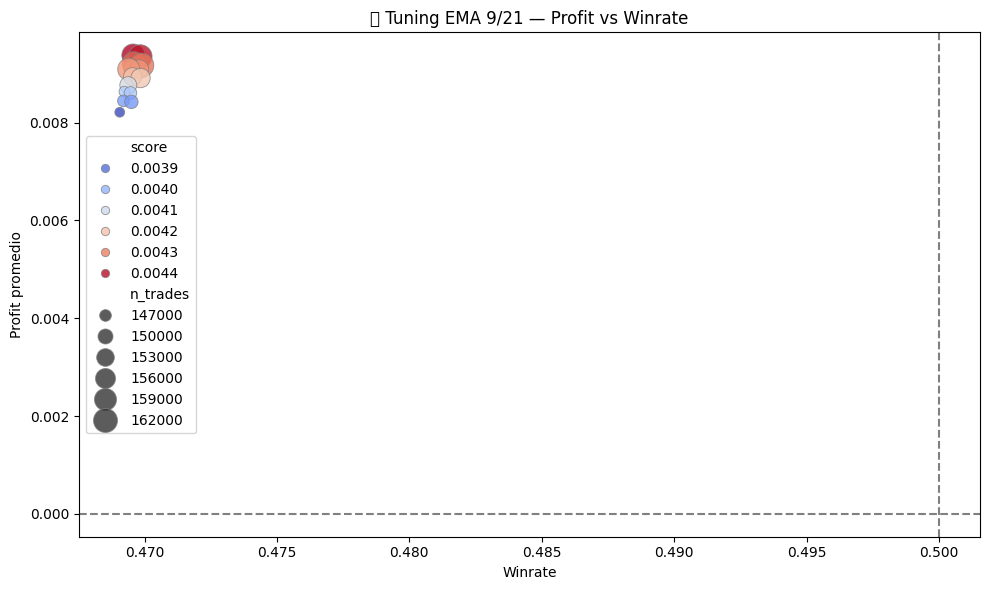

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=resultados,
    x="winrate",
    y="avg_profit",
    size="n_trades",
    hue="score",
    palette="coolwarm",
    sizes=(50, 300),
    alpha=0.8,
    edgecolor="gray"
)
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")
plt.title("🔍 Tuning EMA 9/21 — Profit vs Winrate")
plt.xlabel("Winrate")
plt.ylabel("Profit promedio")
plt.tight_layout()
plt.show()

## 📈 Informe de Resultados: Tuning Estrategia EMA 9/21 Cruce v3

### 🔍 Objetivo
Explorar y afinar los parámetros de la estrategia **ema_9_21_cruce_v3** mediante un segundo grid más fino, tras identificar una región prometedora alrededor de `atr_threshold ≈ 0.008`.

### 🧪 Parámetros evaluados
- `usar_vol`: True (volatilidad siempre aplicada)
- `atr_threshold`: [0.006, 0.0075, 0.008, 0.0085, 0.0095, 0.01]
- `dias_cruce`: [2, 3, 4]

### 📊 Principales resultados
- **Mejor score:** `0.004404` con `atr_threshold = 0.0095` y `dias_cruce = 2`
- El rango ideal se encuentra en:
  - `atr_threshold` entre **0.0075 y 0.0095**
  - `dias_cruce = 2 o 3`, con ligera ventaja para 2
- Se observa un **balance estable** entre profit promedio y winrate, con leve trade-off a medida que aumenta `dias_cruce`.

### 🧠 Conclusión
Este segundo experimento confirma que:
- La estrategia se **beneficia de afinar el umbral ATR** (atr_threshold)
- El parámetro `dias_cruce = 2` ofrece mejor score general
- El rendimiento es **estable y consistente** dentro del rango afinado

### ✅ Recomendación
Proceder con la versión `ema_9_21_cruce_v4` usando los siguientes parámetros por defecto:
- `usar_vol = True`
- `atr_threshold = 0.0095`
- `dias_cruce = 2`
